<a href="https://colab.research.google.com/github/Snafkin547/Quantum-ML/blob/main/QML_Ch10_Bayesian_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit
!pip install numpy scipy matplotlib ipython pandas sympy nose seaborn
!pip install scikit-learn
!pip install pylatexenc ipywidgets qutip
!pip install kaggle

from google.colab import drive
import os

#Google Drive mounting to Google Colab
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/QML/Kaggle"
#Change the working directory
%cd /content/gdrive/My Drive/QML/Kaggle/

#Check if the directory was properly changed
%pwd

import pandas as pd

train=pd.read_csv('./train.csv')

In [3]:
data = [
(1, 1), (1, 1), (0, 0), (0, 0), (0, 0), (0, None), (0, 1), (1, 0)
]

In [30]:
def ccry(qc, theta, control1, control2, controlled):
  qc.cry(theta/2, control2, controlled)
  qc.cx(control1, control2)
  qc.cry(-theta/2, control2, controlled)
  qc.cx(control1, control2)
  qc.cry(theta/2, control1, controlled)

In [4]:
from math import log

def log_likelihood(data, prob_a_b, prob_a_nb, prob_na_b, prob_na_nb):
  def get_prob(point):
    if point[0] == 1 and point[1] == 1:
      return log(prob_a_b)
    elif point[0] == 1 and point[1] == 0:
      return log(prob_a_nb)
    elif point[0] == 0 and point[1] == 1:
      return log(prob_na_b)
    elif point[0] == 0 and point[1] == 0:
      return log(prob_na_nb)
    else:
      return log(prob_na_b+prob_na_nb)
  return sum(map(get_prob, data))

In [5]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from math import asin, sqrt, sin, cos, pi

def prob_to_angle(prob):
  return 2*asin(sqrt(prob))

In [6]:
## Scaffold of PQC

def as_pqc(cunt_quantum, with_qc, cnt_classical=1, shots=1, hist=False, measure=False):

  qr=QuantumRegister(cunt_quantum)
  cr=ClassicalRegister(cnt_classical)
  qc=QuantumCircuit(qr, cr) if measure else QuantumCircuit(qr)

  with_qc(qc, qr=qr, cr=cr)

  results=executed(qc, Aer.get_backend('stevector_simulator') if measure is False else Aer.get_backend('qasm_simulator'), 
                  shots=shots).result().get_counts()
  return plot_histogram(results, figsize=(12,4)) if hist else results
              


In [7]:
def as_pqc(cnt_quantum, with_qc, cnt_classical=1, shots=1, hist=False, measure=False):
# Prepare the circuit with qubits and a classical bit to hold the measurement

  qr = QuantumRegister(cnt_quantum)
  cr = ClassicalRegister(cnt_classical)
  qc = QuantumCircuit(qr, cr) if measure else QuantumCircuit(qr)

  with_qc(qc, qr=qr, cr=cr)

  results = execute(qc,
     Aer.get_backend('statevector_simulator') if measure is False else Aer.get_backend('qasm_simulator'),
     shots=shots).result().get_counts()

  return plot_histogram(results, figsize=(12,4)) if hist else results

In [8]:
def qbn(data, hist=True):
  def circuit(qc, qr=None, cr=None):
    list_a=list(filter(lambda item: item[0]==1, data))
    list_na=list(filter(lambda item: item[0]==0, data))

    # set the marginal probability of A
    qc.ry(prob_to_angle(len(list_a)/len(data)),0)

    # set the conditional probability of Not A and (B/not B)
    qc.x(0)
    qc.cry(prob_to_angle(
        sum(list(map(lambda item: item[1], list_na))) / len(list_na)
    ),0,1)
    qc.x(0)

    # set the conditional probability of A and (B/notB)
    qc.cry(prob_to_angle(
        sum(list(map(lambda item: item[1], list_a)))/len(list_a)
    ),0,1)

  return as_pqc(2, circuit, hist=hist)


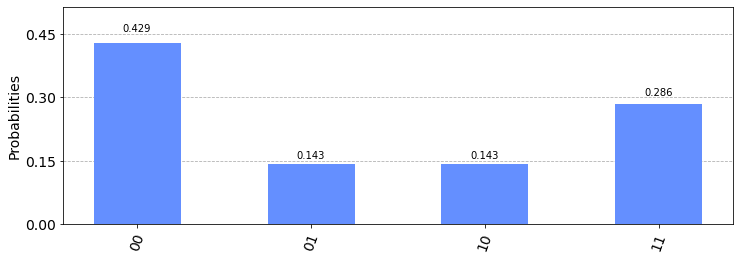

In [9]:
qbn(list(filter(lambda item: item[1] is not None ,data)))

In [10]:
def eval_qbn(model, prepare_data, data):
  results=model(prepare_data(data), hist=False)
  return round(log_likelihood(data,
                              results['11'], # prob_a_b
                              results['01'], # prob_a_nb
                              results['10'], # prob_na_b
                              results['00'], # prob_na_nb
                              ),3)

eval_qbn(qbn, lambda dataset: list(filter(lambda item: item[1] is not None, dataset)), data)

-9.499

In [11]:
eval_qbn(qbn, lambda dataset: list(map(lambda item: item if item[1] is not None else (item[0], 0) ,dataset)), data)

-9.481

In [12]:
def eval_qbn(model, prepare_data, data):
  results=model(prepare_data(data), hist=False)
  return (round(log_likelihood(data,
                              results['11'], # prob_a_b
                              results['01'], # prob_a_nb
                              results['10'], # prob_na_b
                              results['00'], # prob_na_nb
                              ),3), results['10']/(results['10']+results['00']))


In [13]:
eval_qbn(qbn, lambda dataset: list(map(lambda item: item if item[1] is not None else (item[0], 0.5) ,dataset)), data)

(-9.476, 0.3)

In [14]:
eval_qbn(qbn, lambda dataset: list(map(lambda item: item if item[1] is not None else (item[0], 0.3) ,dataset)), data)

(-9.452, 0.26)

In [16]:
max_child_age=8

population_child=train[train['Age']<=max_child_age]
p_child=len(population_child)/len(train)

population_female=train[train['Sex']=="female"]
p_female=len(population_female)/len(train)

QPOS_ISCHILD=0
QPOS_SEX=1

def apply_ischild_sex(qc):
  qc.ry(prob_to_angle(p_child),QPOS_ISCHILD)
  qc.ry(prob_to_angle(p_female),QPOS_SEX)

In [32]:
# Prob of being favored by a norm

QPOS_NORM=2

def apply_norm(qc, norm_params):
  """
  norm_params={
    'p_norm_am: 0.25,
    'p_norm_af: 0.35,
    'p_norm_cm: 0.45,
    'p_norm_cf: 0.55
  }
  """
  # Set the conditional prob of Norm Given Adult/Male
  qc.x(QPOS_ISCHILD)
  qc.x(QPOS_SEX)
  ccry(qc, prob_to_angle(norm_params['p_norm_am']),
       QPOS_ISCHILD, QPOS_SEX, QPOS_NORM)
  qc.x(QPOS_ISCHILD)
  qc.x(QPOS_SEX)

  # Set the conditional prob of Norm Given Adult/Male
  qc.x(QPOS_ISCHILD)
  ccry(qc, prob_to_angle(norm_params['p_norm_af']),
       QPOS_ISCHILD, QPOS_SEX, QPOS_NORM)
  qc.x(QPOS_ISCHILD)
 
  # Set the conditional prob of Norm Given Child/Male
  qc.x(QPOS_SEX)
  ccry(qc, prob_to_angle(norm_params['p_norm_cm']),
       QPOS_ISCHILD, QPOS_SEX, QPOS_NORM)
  qc.x(QPOS_SEX) 

  # Set the conditional prob of Norm Given Adult/Male
  ccry(qc, prob_to_angle(norm_params['p_norm_cf']),
       QPOS_ISCHILD, QPOS_SEX, QPOS_NORM)



In [20]:
pop_first = train[train.Pclass.eq(1)]
surv_first = round(len(pop_first[pop_first.Survived.eq(1)])/len(pop_first), 2)
p_first = round(len(pop_first)/len(train), 2)
pop_second = train[train.Pclass.eq(2)]
surv_second = round(len(pop_second[pop_second.Survived.eq(1)])/len(pop_second), 2)
p_second = round(len(pop_second)/len(train), 2)
pop_third = train[train.Pclass.eq(3)]
surv_third = round(len(pop_third[pop_third.Survived.eq(1)])/len(pop_third), 2)
p_third = round(len(pop_third)/len(train), 2)
print("First class: {} of the passengers, survived: {}".format(p_first,surv_first))
print("Second class: {} of the passengers, survived: {}".format(p_second, surv_second))
print("Third class: {} of the passengers, survived: {}".format(p_third, surv_third))

First class: 0.24 of the passengers, survived: 0.63
Second class: 0.21 of the passengers, survived: 0.47
Third class: 0.55 of the passengers, survived: 0.24


In [41]:
QPOS_FIRST=3
QPOS_SECOND=4
QPOS_THIRD=5

def apply_class(qc):
  # SET first calss
  qc.ry(prob_to_angle(p_first),QPOS_FIRST)
  
  # SET SECOND given pass doesnt have a first calss tix
  qc.x(QPOS_FIRST)
  qc.cry(prob_to_angle(p_second/(1-p_first)), QPOS_FIRST, QPOS_SECOND)

  # SET THIRD given pass doesnt have a first nor sec calss tix
  qc.x(QPOS_SECOND)
  ccry(qc, prob_to_angle(p_third/(1-p_first-p_second)), QPOS_FIRST, QPOS_SECOND, QPOS_THIRD)

  # reverse 
  qc.x(QPOS_SECOND)
  qc.x(QPOS_FIRST)

In [38]:
QPOS_SURV=6


def apply_survival(qc, surv_params):
  """
  surv_params={
    'p_surv_f1': 0.3,
    'p_surv_f2': 0.4,
    'p_surv_f3': 0.5,
    'p_surv_u1': 0.6,
    'p_surv_u2': 0.7,
    'p_surv_u3': 0.8,
  }
  """  
  
  #Prob of survival given unfavored by norm

  qc.x(QPOS_NORM)

  """1st class"""
  ccry(qc, prob_to_angle(surv_params['p_surv_u1']), QPOS_NORM, QPOS_FIRST, QPOS_SURV)

  """2nd class"""
  ccry(qc, prob_to_angle(surv_params['p_surv_u2']), QPOS_NORM, QPOS_SECOND, QPOS_SURV)

  """3rd class"""
  ccry(qc, prob_to_angle(surv_params['p_surv_u3']), QPOS_NORM, QPOS_THIRD, QPOS_SURV)

  qc.x(QPOS_NORM)

  #Prob of survival given favored by norm
  """1st class"""
  ccry(qc, prob_to_angle(surv_params['p_surv_f1']), QPOS_NORM, QPOS_FIRST, QPOS_SURV)

  """2nd class"""
  ccry(qc, prob_to_angle(surv_params['p_surv_f2']), QPOS_NORM, QPOS_SECOND, QPOS_SURV)

  """3rd class"""
  ccry(qc, prob_to_angle(surv_params['p_surv_f3']), QPOS_NORM, QPOS_THIRD, QPOS_SURV)


In [39]:
QUBITS=7

def qbn_titanic(norm_params, surv_params, hist=True, measure=False, shots=1):
  def circuit(qc, qr=None, cr=None):
    apply_ischild_sex(qc)
    apply_norm(qc, norm_params)
    apply_class(qc)
    apply_survival(qc, surv_params)
  return as_pqc(QUBITS, circuit, hist=hist, measure=measure, shots=shots)

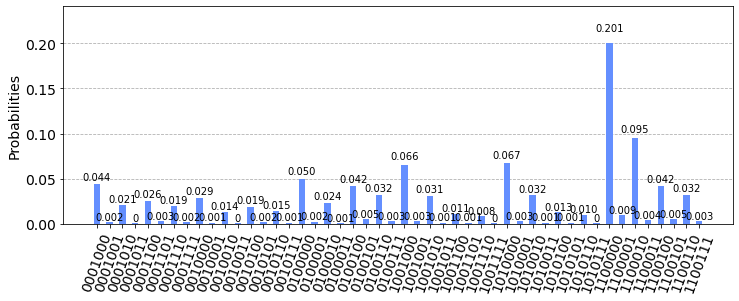

In [42]:
norm_params = {
 'p_norm_am': 0.25,
 'p_norm_af': 0.35,
 'p_norm_cm': 0.45,
 'p_norm_cf': 0.55
 }

surv_params = {
 'p_surv_f1': 0.3,
 'p_surv_f2': 0.4,
 'p_surv_f3': 0.5,
 'p_surv_u1': 0.6,
 'p_surv_u2': 0.7,
 'p_surv_u3': 0.8
 }

qbn_titanic(norm_params, surv_params, hist=True)

In [43]:
def calculate_norm_params(passengers):
  # Child/Adult
  pop_children=passengers[passengers['IsChild']==1]
  pop_adult=passengers[passengers['IsChild']==0]

  # Child/Adult and gender

  pop_am=pop_adult[pop_adult['Sex']=='male']
  pop_af=pop_adult[pop_adult['Sex']=='female']
  pop_cm=pop_children[pop_children['Sex']=='male']
  pop_cf=pop_children[pop_children['Sex']=='female']
  
  norm_params={
      'p_norm_am': pop_am.Norm.sum()/len(pop_am),
      'p_norm_af': pop_af.Norm.sum()/len(pop_af),
      'p_norm_cm': pop_cm.Norm.sum()/len(pop_cm),
      'p_norm_cf': pop_cf.Norm.sum()/len(pop_cf),
  }
  return norm_params

In [45]:
def calculate_surv_params(passengers):
  # all survivors
  survivors=passengers[passengers['Survived']==1]
  
  def weight_passenger(norm, pclass):
    return lambda passenger: (passenger[0] if norm else 1-passenger[0])*(1 if passenger[1]==pclass else 0)
  
  # calculate the probability to surive
  def calc_prob(norm, pclass):
    return sum(list(map(weight_passenger(norm, pclass), 
                        list(zip(survivors['Norm'], survivors['Pclass']))
                    )))/sum(list(map(weight_passenger(norm, pclass),
                     list(zip(passengers['Norm'], passengers['Pclass']))
                    )))
  surv_params = {
    'p_surv_f1': calc_prob(True, 1),
    'p_surv_f2': calc_prob(True, 2),
    'p_surv_f3': calc_prob(True, 3),
    'p_surv_u1': calc_prob(False, 1),
    'p_surv_u2': calc_prob(False, 2),
    'p_surv_u3': calc_prob(False, 3)
  }

  return surv_params


In [46]:
# Prepare norm
def prepare_data(passengers, params):
    """
    params = {
        'p_norm_cms': 0.45,
        'p_norm_cmd': 0.46,
        'p_norm_cfs': 0.47,
        'p_norm_cfd': 0.48,
        'p_norm_ams': 0.49,
        'p_norm_amd': 0.51,
        'p_norm_afs': 0.52,
        'p_norm_afd': 0.53,
    }
    """
    # is the passenger a child?
    passengers['IsChild'] = passengers['Age'].map(lambda age: 0 if age > max_child_age else 1)

    # the probability of favored by norm given Age, Sex, and Survival
    passengers['Norm'] = list(map(
        lambda item: params['p_norm_{}{}{}'.format(
            'a' if item[0] == 0 else 'c',
            item[1][0],
            'd' if item[2] == 0 else 's'
        )],
        list(zip(passengers['IsChild'], passengers['Sex'], passengers['Survived']))
    ))
    return passengers

In [47]:
params = {
    'p_norm_cms': 0.45,
    'p_norm_cmd': 0.46,
    'p_norm_cfs': 0.47,
    'p_norm_cfd': 0.48,
    'p_norm_ams': 0.49,
    'p_norm_amd': 0.51,
    'p_norm_afs': 0.52,
    'p_norm_afd': 0.53,
}

passengers=prepare_data(train, params)
results=qbn_titanic(calculate_norm_params(passengers), calculate_surv_params(passengers), hist=False)

In [50]:
def filter_states(states, position, value):
  return list(filter(lambda item: item[0][QUBITS-1-position] == str(value), states))

In [51]:
filter_states(results.items(), QPOS_SURV, '1')

[('1001000', 0.04521802427481),
 ('1001001', 0.003204510969179),
 ('1001010', 0.023809598395179),
 ('1001011', 0.001694956632945),
 ('1001100', 0.046710931136364),
 ('1001101', 0.002724433421988),
 ('1001110', 0.026223030341536),
 ('1001111', 0.001531873108259),
 ('1010000', 0.029950610381473),
 ('1010001', 0.002122539872988),
 ('1010010', 0.015770525499731),
 ('1010011', 0.001122671468756),
 ('1010100', 0.030453061368568),
 ('1010101', 0.001776186776328),
 ('1010110', 0.017096031546221),
 ('1010111', 0.000998700403519),
 ('1100000', 0.040619362913079),
 ('1100001', 0.002878613033266),
 ('1100010', 0.021388168402732),
 ('1100011', 0.001522579982202),
 ('1100100', 0.040445280069615),
 ('1100101', 0.002358986860305),
 ('1100110', 0.022705559076552),
 ('1100111', 0.001326392674849)]

In [62]:
def sum_states(states):
  return sum(map(lambda item: item[1], states))
print("Survival rate is {0:.2f}%.".format(100*sum_states(filter_states(results.items(), QPOS_SURV, '1'))))

Survival rate is 38.37%.


In [63]:
## Calculate log likelihood
def log_likelihood_titanic(data, results):
    states = results.items()
    
    def calc_prob(norm_val, ischild_val, sex_val, surv_val):
        return sum_states(
            filter_states(
                filter_states(
                    filter_states(
                        filter_states(states, QPOS_SEX, sex_val),
                        QPOS_ISCHILD, ischild_val
                    ), QPOS_SURV, surv_val
                ), QPOS_NORM, norm_val))
        
    probs = {
        'p_fcms': calc_prob('1', '1', '0', '1'),
        'p_fcmd': calc_prob('1', '1', '0', '0'),
        'p_fcfs': calc_prob('1', '1', '1', '1'),
        'p_fcfd': calc_prob('1', '1', '1', '0'),
        'p_fams': calc_prob('1', '0', '0', '1'),
        'p_famd': calc_prob('1', '0', '0', '0'),
        'p_fafs': calc_prob('1', '0', '1', '1'),
        'p_fafd': calc_prob('1', '0', '1', '0'),
        'p_ucms': calc_prob('0', '1', '0', '1'),
        'p_ucmd': calc_prob('0', '1', '0', '0'),
        'p_ucfs': calc_prob('0', '1', '1', '1'),
        'p_ucfd': calc_prob('0', '1', '1', '0'),
        'p_uams': calc_prob('0', '0', '0', '1'),
        'p_uamd': calc_prob('0', '0', '0', '0'),
        'p_uafs': calc_prob('0', '0', '1', '1'),
        'p_uafd': calc_prob('0', '0', '1', '0'),
    }

    return round(sum(map(
        lambda item: log(probs['p_{}{}{}{}'.format(
                'u',
                'a' if item[1] == 0 else 'c',
                item[2][0],
                'd' if item[3] == 0 else 's'
            )] + probs['p_{}{}{}{}'.format(
                'f',
                'a' if item[1] == 0 else 'c',
                item[2][0],
                'd' if item[3] == 0 else 's'
            )]
        ),
        list(zip(data['Norm'], data['IsChild'], data['Sex'], data['Survived']))
    )), 3)

In [64]:
log_likelihood_titanic(train, results)

-1860.391

In [66]:
def to_params(results):
  states=results.items()

  def calc_norm(ischild_val, sex_val, surv_val):
    pop=filter_states(filter_states(filter_states(states, QPOS_SEX, sex_val), QPOS_ISCHILD, ischild_val), QPOS_SURV, surv_val)

    p_norm=sum(map(lambda item: item[1], filter_states(pop, QPOS_NORM, '1')))
    p_total=sum(map(lambda item: item[1], pop))
    return p_norm/p_total
    
  return {
        'p_norm_cms': calc_norm('1', '0', '1'),
        'p_norm_cmd': calc_norm('1', '0', '0'),
        'p_norm_cfs': calc_norm('1', '1', '1'),
        'p_norm_cfd': calc_norm('1', '1', '0'),
        'p_norm_ams': calc_norm('0', '0', '1'),
        'p_norm_amd': calc_norm('0', '0', '0'),
        'p_norm_afs': calc_norm('0', '1', '1'),
        'p_norm_afd': calc_norm('0', '1', '0'),
    }
to_params(results)

{'p_norm_afd': 0.5239923091774149,
 'p_norm_afs': 0.5199079166576689,
 'p_norm_amd': 0.5079933634215902,
 'p_norm_ams': 0.5039016630401505,
 'p_norm_cfd': 0.47460383062928546,
 'p_norm_cfs': 0.47052387314654737,
 'p_norm_cmd': 0.4593883474337892,
 'p_norm_cms': 0.45532583440735436}

In [70]:
def train_qbn_titanic(passengers, params, iterations):
  if iterations>0:
     #iterating 
      new_params=train_qbn_titanic(passengers, params, iterations-1)

      passengers=prepare_data(passengers, new_params)
      results=qbn_titanic(calculate_norm_params(passengers),
                          calculate_surv_params(passengers), hist=False)
      
      print ('The log−likelihood after {} iteration(s) is {}'.format(iterations, log_likelihood_titanic(passengers, results)))
      return to_params(results)
  return params

In [71]:
trained_params = train_qbn_titanic(train, {
    'p_norm_cms': 0.45,
    'p_norm_cmd': 0.46,
    'p_norm_cfs': 0.47,
    'p_norm_cfd': 0.48,
    'p_norm_ams': 0.49,
    'p_norm_amd': 0.51,
    'p_norm_afs': 0.52,
    'p_norm_afd': 0.53,
}, 25)

The log−likelihood after 1 iteration(s) is -1860.391
The log−likelihood after 2 iteration(s) is -1860.355
The log−likelihood after 3 iteration(s) is -1860.332
The log−likelihood after 4 iteration(s) is -1860.3
The log−likelihood after 5 iteration(s) is -1860.243
The log−likelihood after 6 iteration(s) is -1860.13
The log−likelihood after 7 iteration(s) is -1859.901
The log−likelihood after 8 iteration(s) is -1859.426
The log−likelihood after 9 iteration(s) is -1858.439
The log−likelihood after 10 iteration(s) is -1856.393
The log−likelihood after 11 iteration(s) is -1852.213
The log−likelihood after 12 iteration(s) is -1843.99
The log−likelihood after 13 iteration(s) is -1829.057
The log−likelihood after 14 iteration(s) is -1805.719
The log−likelihood after 15 iteration(s) is -1777.24
The log−likelihood after 16 iteration(s) is -1752.49
The log−likelihood after 17 iteration(s) is -1737.602
The log−likelihood after 18 iteration(s) is -1730.95
The log−likelihood after 19 iteration(s) is 

In [72]:
trained_params

{'p_norm_afd': 0.9590619707415071,
 'p_norm_afs': 0.9978526500251851,
 'p_norm_amd': 0.046546425010374065,
 'p_norm_ams': 0.491959274240783,
 'p_norm_cfd': 0.8392179490424748,
 'p_norm_cfs': 0.9904336919724537,
 'p_norm_cmd': 0.07088902981523437,
 'p_norm_cms': 0.6021334301302408}

### Predict Survival

In [73]:
def pre_process(passenger):
  return (passenger['IsChild']==1, passenger['Sex']=='female', passenger['Pclass'])

In [74]:
def apply_known(qc, is_child, is_female, pclass):
  if is_child:
    qc.x(QPOS_ISCHILD)
  if is_female:
    qc.x(QPOS_SEX)
  
  qc.x(QPOS_FIRST if pclass==1 else (QPOS_SECOND if pclass == 2 else QPOS_THIRD))

In [79]:
def get_trained_qbn(passengers, params):
  prepared_passengers=prepare_data(passengers, params)
  norm_params=calculate_norm_params(prepared_passengers)
  surv_params=calculate_surv_params(prepared_passengers)

  def trained_qbn_titanic(passenger):
    (is_child, is_female, pclass) = passenger

    def circuit(qc, qr, cr):
      apply_known(qc, is_child, is_female, pclass)
      apply_norm(qc, norm_params)
      apply_survival(qc, surv_params)
      qc.measure(qr[QPOS_SURV], cr[0])
    return as_pqc(QUBITS, circuit, hist=False, measure=True, shots=100)
    
  return trained_qbn_titanic

In [77]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


#Ratio of True Negatives amongst all actual negatives
def specificity(matrix):
    return matrix[0][0]/(matrix[0][0]+matrix[0][1]) if (matrix[0][0]+matrix[0][1] > 0) else 0

## Negative Predictive Value
def npv(matrix):
    return matrix[0][0]/(matrix[0][0]+matrix[1][0]) if (matrix[0][0]+matrix[1][0] > 0) else 0

def classifier_report(name, run, classify, input, labels):
  cr_predictions=run(classify, input)
  cr_cm=confusion_matrix(labels, cr_predictions)
  
  cr_precision=precision_score(labels, cr_predictions)
  cr_recall=recall_score(labels, cr_predictions)
  cr_specificity=specificity(cr_cm)
  cr_npv=npv(cr_cm)
  cr_level=0.25*(cr_precision+cr_recall+cr_specificity+cr_npv)

  print('The precision score of the {} classifier is {:.2f}'.format(name, cr_precision))
  print('The recall score of the {} classifier is {:.2f}'.format(name, cr_recall))
  print('The specificity score of the {} classifier is {:.2f}'.format(name, cr_specificity))
  print('The npv score of the {} classifier is {:.2f}'.format(name, cr_npv))
  print('The information level is: {:.2f}'.format(cr_level))

In [76]:
def post_process(counts):
  p_surv=counts['1'] if '1' in counts.keys() else 0
  p_died=counts['0'] if '0' in counts.keys() else 0

  return 1 if p_surv > p_died else 0

In [81]:
def run(f_classify, data):
  return [f_classify(data.iloc[i]) for i in range(0, len(data))]

trained_qbn = get_trained_qbn(train, trained_params)

classifier_report("QBN",
                  run,
                  lambda passenger: post_process(trained_qbn(pre_process(passenger))),
                  passengers,
                  train['Survived'])

The precision score of the QBN classifier is 0.77
The recall score of the QBN classifier is 0.59
The specificity score of the QBN classifier is 0.89
The npv score of the QBN classifier is 0.78
The information level is: 0.76
